In [41]:
import glob

from src.create_annotations import *

# Label ids of the dataset
category_ids = {
    "background": 0,
    "plant": 1,
    "weed": 2
 
}

# Define which colors match which categories in the images
category_colors = {
    "(0, 0, 0)": 0, # background
    "(0, 255, 0)": 1, # plant
    "(255, 0, 0)": 2, # weed
}

# Define the ids that are a multiplolygon. In our case: wall, roof and sky
multipolygon_ids = [0,1]

# Get "images" and "annotations" info 
def images_annotations_info(maskpath):
    # This id will be automatically increased as we go
    annotation_id = 0
    image_id = 0
    annotations = []
    images = []
    
    for mask_image in glob.glob(maskpath + "*.png"):
        # The mask image is *.png but the original image is *.jpg.
        # We make a reference to the original file in the COCO JSON file
        original_file_name = os.path.basename(mask_image).split(".")[0] + ".jpg"

        # Open the image and (to be sure) we convert it to RGB
        mask_image_open = Image.open(mask_image).convert("RGB")
        w, h = mask_image_open.size
        
        # "images" info 
        image = create_image_annotation(original_file_name, w, h, image_id)
        images.append(image)

        sub_masks = create_sub_masks(mask_image_open, w, h)
        for color, sub_mask in sub_masks.items():
            category_id = category_colors[color]

            # "annotations" info
            polygons, segmentations = create_sub_mask_annotation(sub_mask)

            # Check if we have classes that are a multipolygon
            if category_id in multipolygon_ids:
                # Combine the polygons to calculate the bounding box and area
                multi_poly = MultiPolygon(polygons)
                                
                annotation = create_annotation_format(multi_poly, segmentations, image_id, category_id, annotation_id)

                annotations.append(annotation)
                annotation_id += 1
            else:
                for i in range(len(polygons)):
                    # Cleaner to recalculate this variable
                    segmentation = [np.array(polygons[i].exterior.coords).ravel().tolist()]
                    
                    annotation = create_annotation_format(polygons[i], segmentation, image_id, category_id, annotation_id)
                    
                    annotations.append(annotation)
                    annotation_id += 1
        image_id += 1
    return images, annotations, annotation_id

if __name__ == "__main__":
    # Get the standard COCO JSON format
    coco_format = get_coco_json_format()
    
    for keyword in ["train", "val"]:
        mask_path = "dataset_crop3/{}_mask/".format(keyword)
        
        # Create category section
        coco_format["categories"] = create_category_annotation(category_ids)
    
        # Create images and annotations sections
        coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

        with open("output_crop3/{}.json".format(keyword),"w") as outfile:
            json.dump(coco_format, outfile)
        
        print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))


Created 525 annotations for images in folder: dataset_crop3/train_mask/
Created 102 annotations for images in folder: dataset_crop3/val_mask/


## View Annotations

In [42]:
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
import base64
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

In [54]:
# Load the dataset json
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = colors = ['blue', 'red', 'purple', 'green', 'orange', 'salmon', 'pink', 'gold',
                                'orchid', 'slateblue', 'limegreen', 'seagreen', 'darkgreen', 'olive',
                               'teal', 'aquamarine', 'steelblue', 'powderblue', 'dodgerblue', 'navy',
                               'magenta', 'sienna', 'maroon']
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()
            
        
    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, show_crowds=True, use_url=False):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        if use_url:
            image_path = image['coco_url']
            response = requests.get(image_path)
            image = PILImage.open(BytesIO(response.content))
            
        else:
            image_path = os.path.join(self.image_dir, image['file_name'])
            image = PILImage.open(image_path)
            
            buffer = BytesIO()
            image.save(buffer, format='PNG')
            buffer.seek(0)
            
            data_uri = base64.b64encode(buffer.read()).decode('ascii')
            image_path = "data:image/png;base64,{0}".format(data_uri)
            
        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        print('  segmentations ({}):'.format(len(self.segmentations[image_id])))
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []
            if segm['iscrowd'] != 0:
                # Gotta decode the RLE
                px = 0
                x, y = 0, 0
                rle_list = []
                for j, counts in enumerate(segm['segmentation']['counts']):
                    if j % 2 == 0:
                        # Empty pixels
                        px += counts
                    else:
                        # Need to draw on these pixels, since we are drawing in vector form,
                        # we need to draw horizontal lines on the image
                        x_start = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_start = trunc(px % image_height * adjusted_ratio)
                        px += counts
                        x_end = trunc(trunc(px / image_height) * adjusted_ratio)
                        y_end = trunc(px % image_height * adjusted_ratio)
                        if x_end == x_start:
                            # This is only on one line
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1 , 'height': (y_end - y_start)})
                        if x_end > x_start:
                            # This spans more than one line
                            # Insert top line first
                            rle_list.append({'x': x_start, 'y': y_start, 'width': 1, 'height': (image_height - y_start)})
                            
                            # Insert middle lines if needed
                            lines_spanned = x_end - x_start + 1 # total number of lines spanned
                            full_lines_to_insert = lines_spanned - 2
                            if full_lines_to_insert > 0:
                                full_lines_to_insert = trunc(full_lines_to_insert * adjusted_ratio)
                                rle_list.append({'x': (x_start + 1), 'y': 0, 'width': full_lines_to_insert, 'height': image_height})
                                
                            # Insert bottom line
                            rle_list.append({'x': x_end, 'y': 0, 'width': 1, 'height': y_end})
                if len(rle_list) > 0:
                    rle_regions[segm['id']] = rle_list  
            else:
                # Add the polygon segmentation
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    polygons_list.append(str(segmentation_points).lstrip('[').rstrip(']'))
            polygons[segm['id']] = polygons_list
            if i < len(self.colors):
                poly_colors[segm['id']] = self.colors[i]
            else:
                poly_colors[segm['id']] = 'white'
            
            bbox = segm['bbox']
            bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                           bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                           bbox[0], bbox[1]]
            bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
            bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
            
            # Print details
            print('    {}:{}:{}'.format(segm['id'], poly_colors[segm['id']], self.categories[segm['category_id']]))
        
        
        
        # Draw segmentation polygons on image
        html  = '<div class="container" style="position:relative;">'
        html += '<img src="{}" style="position:relative;top:0px;left:0px;width:{}px;">'.format(image_path, adjusted_width)
        html += '<div class="svgclass"><svg width="{}" height="{}">'.format(adjusted_width, adjusted_height)
        
        if show_polys:
            for seg_id, points_list in polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for points in points_list:
                    html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5" />'.format(points, fill_color, stroke_color)
        
        if show_crowds:
            for seg_id, rect_list in rle_regions.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                for rect_def in rect_list:
                    x, y = rect_def['x'], rect_def['y']
                    w, h = rect_def['width'], rect_def['height']
                    html += '<rect x="{}" y="{}" width="{}" height="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0.5; stroke-opacity:0.5" />'.format(x, y, w, h, fill_color, stroke_color)
            
        if show_bbox:
            for seg_id, points in bbox_polygons.items():
                fill_color = poly_colors[seg_id]
                stroke_color = poly_colors[seg_id]
                html += '<polygon points="{}" style="fill:{}; stroke:{}; stroke-width:1; fill-opacity:0" />'.format(points, fill_color, stroke_color)
                
        html += '</svg></div>'
        html += '</div>'
        html += '<style>'
        html += '.svgclass { position:absolute; top:0px; left:0px;}'
        html += '</style>'
        return html
       
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            super_category = category['supercategory']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))

            # Add category to super_categories dict
            if super_category not in self.super_categories:
                self.super_categories[super_category] = {cat_id} # Create a new set with the category id
            else:
                self.super_categories[super_category] |= {cat_id} # Add category id to the set
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [55]:
annotation_path = './output_crop3/val.json'
image_dir = './dataset_crop3/val'

coco_dataset = CocoDataset(annotation_path, image_dir)
coco_dataset.display_categories()

Categories:
  super_category: background
    id 0: background

  super_category: plant
    id 1: plant

  super_category: weed
    id 2: weed



Image:
  file_name: 052.jpg
  height: 966
  width: 1296
  id: 0
  segmentations (38):
    0:blue:{'supercategory': 'background', 'id': 0, 'name': 'background'}
    1:red:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    2:purple:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    3:green:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    4:orange:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    5:salmon:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    6:pink:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    7:gold:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    8:orchid:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    9:slateblue:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    10:limegreen:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    11:seagreen:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    12:darkgreen:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
    13:olive:{'supercategory': 'weed', 'id': 2, 'name': 'weed'}
  


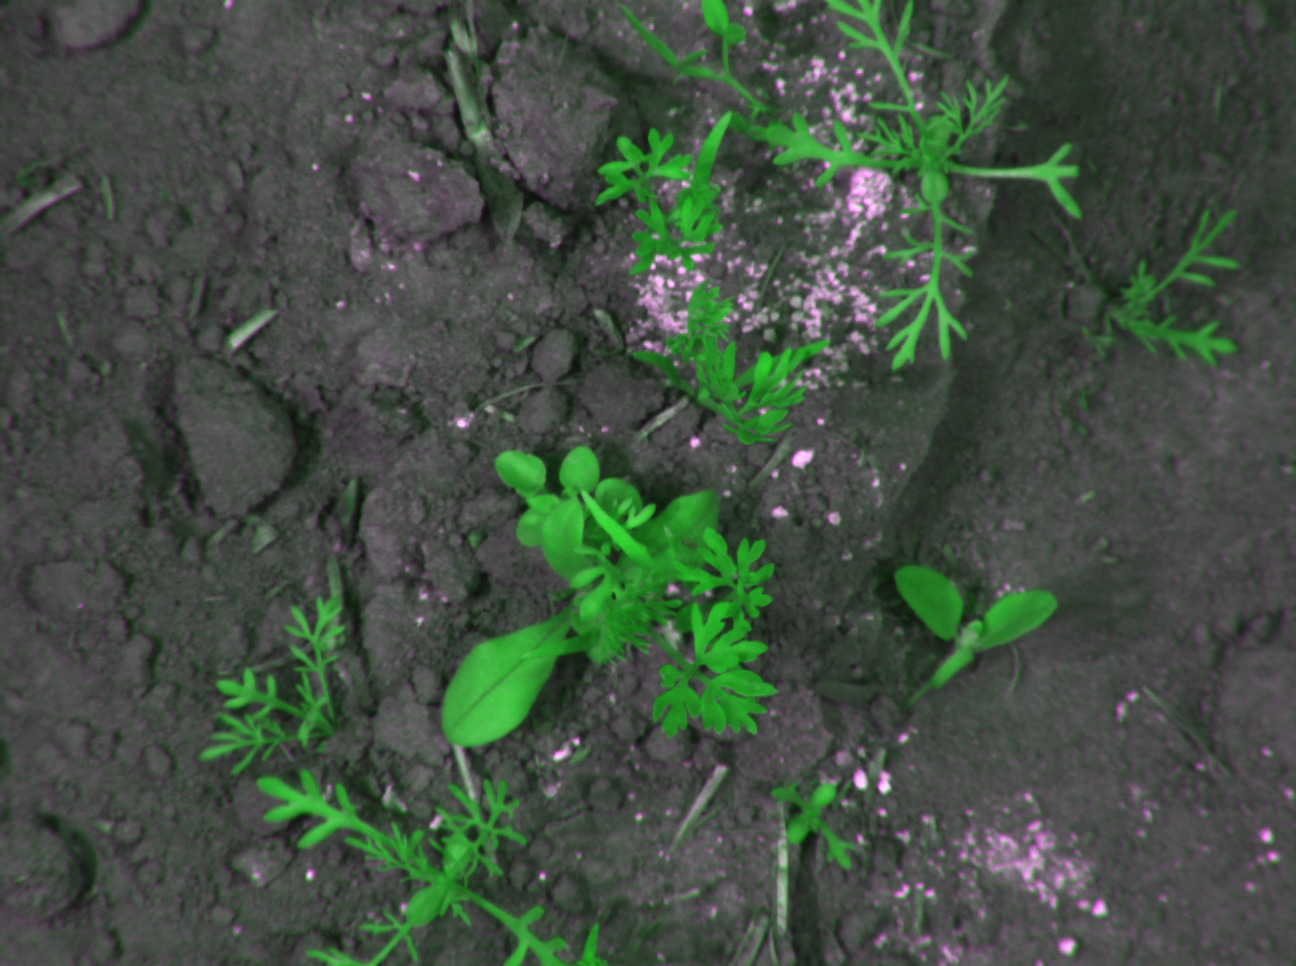

In [56]:
html = coco_dataset.display_image(0)
IPython.display.HTML(html)